Here I'll be exploring the dataset based on the users tagged in certain posts. Working with this spin-off of the original dataset, see how easy it is to predict whether or not a certain tagged profile and thus inclusion in that post means it is more or less likely to receive more engagements. 

# In the block below, the remainder of this notebook are condensed into a single function. 

In [7]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('husl')
%matplotlib inline


def make_num(z):
    """
    Helper function for scraping tool. The result of a follower pull is 
    
    "35m followers", which this function will convert into 35 
    
    Parameters
    ----------
    
    z : str
        The follower count, given as "46m followers"
        
    Returns
    -------
    
    num : float
        The converted number, or 4.6e6. 
        
        Note this may occasionally return NaN, which means the account tagged was not actually found. 
    
    """
    import re
    from numpy import nan
    if type(z) == type(nan):
        return
    
    z = z.split()[0] #not the followers part
    z = z.replace(',','')
    num = re.split(r'[a-z]*',z)[0]
    order = "".join(re.findall(r'[a-z]*',z))
    if order == 'm':
        num = float(num) * 1e6
    if order == 'k':
        num = float(num) * 1e3
    else:
        num = float(num)
    
   # print("Followers = ", num)
    return num

def get_followers(z,driver):
    """
    Obtains follower count for profile in profile df. 
    
    Parameters
    ----------
    
    z : str
        The account name, done via an apply statement. 
        
    driver : WebDriver
        Selenium webdriver object, used to naviagate to the URL of each account, and then grab the corresponding
        followers. 
        
    Returns 
    -------
    
    followers : float
        The number of followers of that particular user. 

    """
    from time import sleep
    from random import randint
    z = z.replace('@','')#.replace(' ','').replace('Â','').replace('å','').replace('â','') #clean unnecesary characters
   # print("Account: ", z)
    url =  driver.get("https://www.instagram.com/"+ z + "/?hl=en")
    sleep(randint(1,3))
    hrefs_in_view = driver.find_elements_by_tag_name('a')
    for elem in hrefs_in_view:
        if elem.get_attribute('href') ==  "https://www.instagram.com/accounts/login/?next=%2F"+z+"%2Ffollowers%2F&source=followed_by_list": #'https://www.instagram.com/'+z+'/followers/':
            
            followers = make_num(elem.text)
            
            return followers
        
        
def load_tagged_profiles(instas):
    """
    
    Creates a dataset summarizing the instagram accounts tagged in the post. 
    The columns used are a temporary list, and this line will be finalized once it is. 
    
    
    Parameters
    ----------
    
    instas : df
        Dataframe of the instagram posts, their associated information + output of engagements
        
        
    Returns
    -------
    
    
    profile_df : df
    
        Dataframe of the profiles tagged in any or multiple posts. 
        
    """
    #use regular expression to obtain any time a name is used, find all
    import re
    posts = " ".join(instas['Description'].unique()).lower() #combine into a corpus, isolating each tag. 
    tagged_profiles = list( dict.fromkeys(re.findall('@[a-z_0-9]*',posts)) ) 
   # print("Total profiles: ", len(tagged_profiles))
    #iterate through these accounts, obtain info regarding how they are engaged. 
    d = []
    for account in tagged_profiles:
        posts_w_account = instas.loc[instas['Description'].str.contains(account)]
        max_eng = posts_w_account.Engagements.max()
        tot_eng = posts_w_account.Engagements.sum()
        n_posts = posts_w_account.Engagements.count()
        min_eng = posts_w_account.Engagements.min()
        avg_eng = posts_w_account.Engagements.mean()
        std_eng = posts_w_account.Engagements.std()
        d.append({'profile': account, 'max_eng': max_eng,'tot_eng' : tot_eng, 
                 'n_posts' : n_posts, 'min_eng' : min_eng, 'avg_eng' : avg_eng, 'std_eng' : std_eng})
   
    profile_df = pd.DataFrame(d)
    #but we're not done, can also establish how popular these accounts are, doing it based on follower count. 
    from selenium import webdriver
    driver = webdriver.Chrome('/Users/noahkasmanoff/Desktop/chromedriver') #open up chrome/spotify
    profile_df['followers']  = profile_df['profile'].apply(lambda z: get_followers(z,driver))
    driver.close()
    
    return profile_df

instas = pd.read_csv('Business Analytics/training_set.csv',encoding = 'unicode_escape')

instas.dropna(inplace=True)


profile_df = load_tagged_profiles(instas)

/Users/noahkasmanoff/anaconda/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [9]:
profile_df

,avg_eng,max_eng,min_eng,n_posts,profile,std_eng,tot_eng,followers
0,484883.253521,848228.0,198217.0,213,@raptors,166178.015873,103280133,2300000.0
1,541361.461538,848228.0,127816.0,13,@sergeibaka,181581.297429,7037699,859000.0
2,633178.625000,723934.0,502093.0,8,@normanpowell4,83453.207631,5065429,192000.0
3,601731.142857,696478.0,502093.0,7,@fredvanvleet,68670.125881,4212118,204000.0
4,587078.422222,854893.0,280401.0,45,@kyle_lowry7,130775.656065,26418529,1200000.0
5,569430.888889,706452.0,154757.0,9,@k_mid22,162026.064528,5124878,170000.0
6,487691.492147,810070.0,217833.0,191,@bucks,155108.514210,93149075,1800000.0
7,628543.834197,956368.0,253363.0,193,@giannis_an34,123631.732902,121308960,5000000.0
8,603939.379310,941443.0,304981.0,87,@lukadoncic,131724.565217,52542726,2600000.0
9,616215.732143,898784.0,287156.0,56,@traeyoung,115901.119416,34508081,1400000.0


avg_eng       11
max_eng       11
min_eng       11
n_posts        0
profile        0
std_eng      304
tot_eng        0
followers     24
dtype: int64

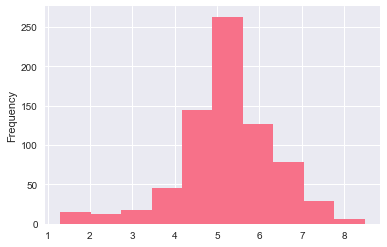

In [11]:
np.log10(profile_df.loc[profile_df['followers'] > 0 ]['followers']).plot(kind='hist')

So ignoring the faulty entries, the # of followers obeys some kind of distribution, which may be useful. 

/Users/noahkasmanoff/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


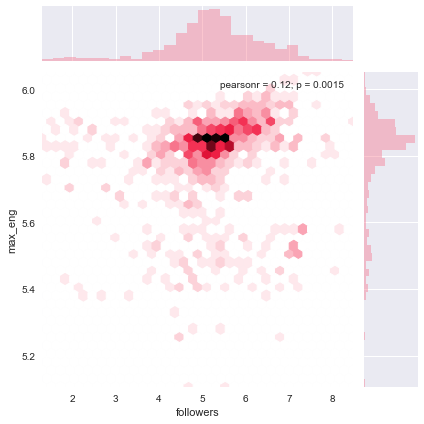

In [20]:
sns.jointplot(x='followers',y='max_eng',data=np.log10(profile_df.loc[profile_df['followers'] > 0 ][['followers','max_eng']]),kind='hex')

In [ ]:
p = pd.read_csv('Business Analytics/profile_df.csv')

In [ ]:
print(p.iloc[[7]].profile.values[0].replace('@','').replace(' ',''))

In [ ]:
'Â'

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('husl')
%matplotlib inline

In [ ]:
instas = pd.read_csv('Business Analytics/training_setv2.csv',encoding = 'unicode_escape')

In [ ]:
instad

If no description, just drop for now. 

In [ ]:
instas.dropna(inplace=True)

In [ ]:
#first, obtain a list of stars tagged. 
import re #use regular expression to obtain any time a name is used, find all

posts = " ".join(instas['Description'].unique())
tagged_profiles = list( dict.fromkeys(re.findall('@\w*',posts)) ) 


In [ ]:
d = []
for account in tagged_profiles:
    posts_w_account = instas.loc[instas['Description'].str.contains(account)]
    max_eng = posts_w_account.Engagements.max()
    tot_eng = posts_w_account.Engagements.sum()
    n_posts = posts_w_account.Engagements.count()
    min_eng = posts_w_account.Engagements.min()
    avg_eng = posts_w_account.Engagements.mean()
    var_eng = posts_w_account.Engagements.std()
    cluster = posts_w_account.cluster.mean() #average cluster designation, 
    d.append({'profile': account, 'max_eng': max_eng,'tot_eng' : tot_eng, 
             'n_posts' : n_posts, 'min_eng' : min_eng, 'avg_eng' : avg_eng, 'cluster' : cluster, 'var_eng' : var_eng})

profile_df = pd.DataFrame(d)

Cluster is now a continuous value corresponding to likelihood to be a popular (group 0) post, which is 1 - cluster number currently, but I should definitely switch this to be the other way around.  

In [ ]:
np.log10(profile_df['avg_eng']).plot(kind='hist')

In [ ]:
profile_df['avg_eng'].plot(kind='hist')

In [ ]:
profile_df['var_eng'].plot(kind='hist')

In [ ]:
profile_df['max_eng'].plot(kind='hist')

In [ ]:
#make a list of stars



stars = ['@easymoneysniper','@kingjames','@stephencurry30','@kyrieirving','@dwyanewade','@russwest44','@cp3','@jharden13','@lukadoncic','@ygtrece'
         ,'@carmeloanthony','@klaythompson']

In [ ]:
profile_df['Star?'] = profile_df['profile'].apply(lambda z: 1 if z in stars else 0)

From https://www.adweek.com/digital/instagram-nba-players-teams-february-2017/, here's a list of stars and also most popular players. Perhaps this affects how many people view a post? 

In [ ]:
profile_df.loc[profile_df['profile'] == '@kingjames']

In [ ]:
sns.pairplot(profile_df,hue='Star?')

In [ ]:
profile_df.to_csv('Business Analytics/profile_df.csv',index=False)